In [ ]:
# This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM)
# to predict the closing stock price of a corporation (Apple Inc.) using the past 60 day stock price

In [24]:
import math
from pandas_datareader import data as pdr
import yfinance as yfin
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [40]:
yfin.pdr_override()
df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end='2019-12-17')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.500195,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.567369,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.706896,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.839728,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.819365,394024400
...,...,...,...,...,...,...
2019-12-10,67.150002,67.517502,66.464996,67.120003,65.655716,90420400
2019-12-11,67.202499,67.775002,67.125000,67.692497,66.215706,78756800
2019-12-12,66.945000,68.139999,66.830002,67.864998,66.384460,137310400


In [4]:
# get the number of rows and columns in the dataset
df.shape

(2002, 6)

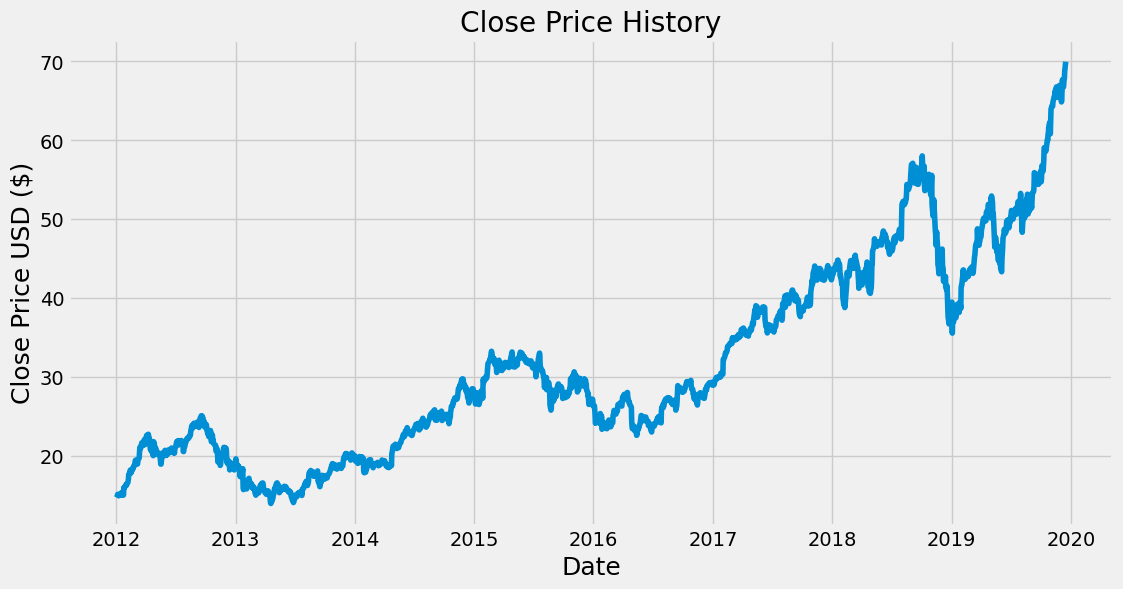

In [5]:
# visualize the closing price history
plt.figure(figsize=(12,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [6]:
# create a new dataframe with only the `Close` column
data = df.filter(['Close'])
# convert the dateframe to a numpy array
dataset = data.values
# get the number of rows to traing the model on
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1602

In [7]:
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [8]:
# create the training data set
# create the scaled training data set
train_data =scaled_data[0:training_data_len, :]
# split the data into x_train and y_train sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

In [9]:
# convert the x_train and y_train to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
# reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1542, 60, 1)

In [11]:
# build the lstm model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1542/1542 [==============================] - 53s 31ms/step - loss: 8.5854e-04


In [14]:
# create the testing data set
# create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60:, :]
# create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [15]:
# convert the data to a numpy array
x_test = np.array(x_test)

In [16]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [17]:
# get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

13/13 [==============================] - 1s 17ms/step


In [28]:
# get the root mean squared error (RMSE)
rmse = np.sqrt( np.mean( ( (predictions- y_test)**2) ) )

<ipython-input-29-a850d183da26>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


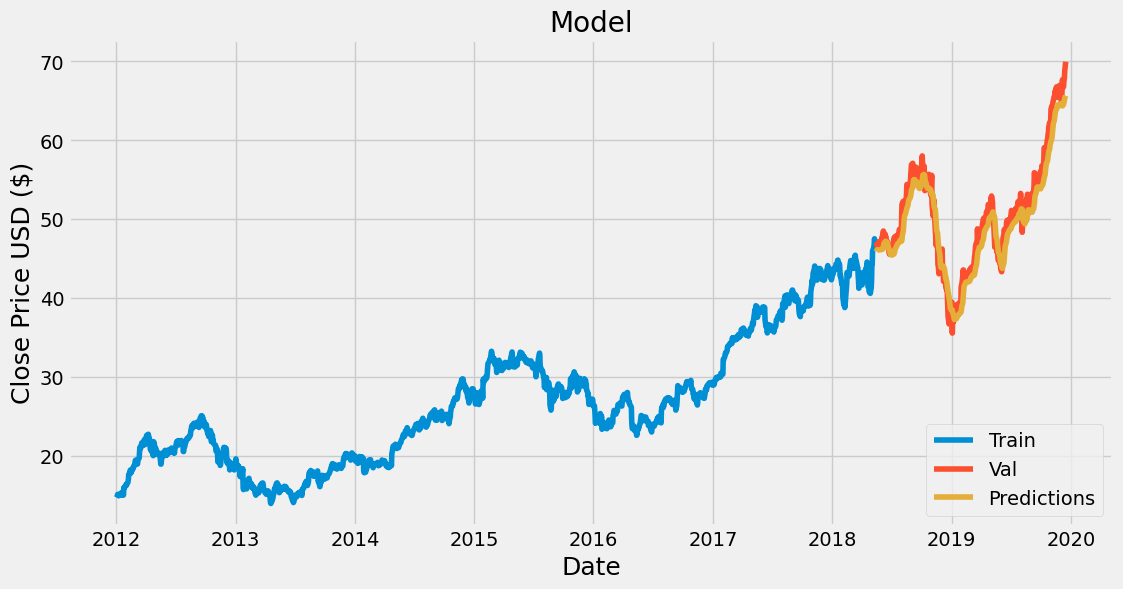

In [29]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = predictions
plt.figure(figsize=(12,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [30]:
# show the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-05-16,47.044998,45.897446
2018-05-17,46.747501,46.052547
2018-05-18,46.577499,46.121006
2018-05-21,46.907501,46.118320
2018-05-22,46.790001,46.112099
...,...,...
2019-12-10,67.120003,64.675163
2019-12-11,67.692497,64.847115
2019-12-12,67.864998,65.073891


In [31]:
# get the quote
apple_quote = pdr.get_data_yahoo('AAPL', start='2012-01-01', end='2019-12-17')

# create a new dataframe
new_df = apple_quote.filter(['Close'])

# get the last 60 days closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values

# scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

# create an empty list
x_test = []

# append the past 60 days
x_test.append(last_60_days_scaled)

# convert the x_test dataset to a numpy array
x_test = np.array(x_test)

# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# get the predicted scaled price
pred_price = model.predict(x_test)

#undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 28ms/step
[[66.11705]]


In [39]:
# get the quote
apple_quote = pdr.get_data_yahoo('AAPL', start='2019-12-17', end='2019-12-19')
apple_quote['Close']

[*********************100%***********************]  1 of 1 completed


Date
2019-12-17    70.102501
2019-12-18    69.934998
Name: Close, dtype: float64